Data preprocessing and merging datasets

In [ ]:
from zipfile import ZipFile, BadZipFile
import os

zip_file_path = '/content/drive/MyDrive/archive (4).zip'
extraction_directory = '/content/drive/MyDrive/3classes'

if not os.path.exists(extraction_directory):
    os.makedirs(extraction_directory)

try:
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_directory)

    extracted_files = os.listdir(extraction_directory)
    print(extracted_files[:10])

except BadZipFile:
    print(f"Error: {zip_file_path} is not a valid zip file.")
    # Handle the case where the zip file is invalid
    # (e.g., re-download, prompt the user, etc.)

['test', 'train', 'val']


In [ ]:
import os

def count_files_in_directory(directory_path):
    file_count = len([file for file in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, file))])
    return file_count

directory_path = "/content/drive/MyDrive/3classes/val/TURBERCULOSIS"
print("Number of files:", count_files_in_directory(directory_path))


Number of files: 140


In [ ]:
import os

def count_directories_in_directory(directory_path):
    dir_count = len([item for item in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, item))])
    return dir_count

directory_path = "/content/drive/MyDrive/3classes/train"
print("Number of subdirectories:", count_directories_in_directory(directory_path))


Number of subdirectories: 3


In [ ]:
import os
import shutil

def move_images(source_dir, destination_dir, num_images, extensions=None):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)  # Create destination directory if it doesn't exist


        extensions = {'.jpg', '.png', '.jpeg'}

    moved_count = 0
    for filename in os.listdir(source_dir):
        if moved_count >= num_images:
            break  # Stop once the desired number of images are moved

        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)

        # Check if it's an image file with one of the specified extensions
        if os.path.isfile(source_path) and any(filename.endswith(ext) for ext in extensions):
            shutil.move(source_path, destination_path)
            moved_count += 1
            print(f"Moved: {filename}")

    print(f"Total images moved: {moved_count}")

source_dir = "/content/drive/MyDrive/tuberculosisdezip/TB_Chest_Radiography_Database/Normal"
destination_dir = "/content/drive/MyDrive/NORMAL"
num_images = 3372
move_images(source_dir, destination_dir, num_images)



Moved: Normal-1113.png
Moved: Normal-1114.png
Moved: Normal-1115.png
Moved: Normal-1116.png
Moved: Normal-1117.png
Moved: Normal-1118.png
Moved: Normal-1119.png
Moved: Normal-112.png
Moved: Normal-1120.png
Moved: Normal-1121.png
Moved: Normal-1122.png
Moved: Normal-1123.png
Moved: Normal-1124.png
Moved: Normal-1125.png
Moved: Normal-1126.png
Moved: Normal-1127.png
Moved: Normal-1128.png
Moved: Normal-1129.png
Moved: Normal-113.png
Moved: Normal-1130.png
Moved: Normal-1131.png
Moved: Normal-1132.png
Moved: Normal-1133.png
Moved: Normal-1134.png
Moved: Normal-1135.png
Moved: Normal-1136.png
Moved: Normal-1137.png
Moved: Normal-1138.png
Moved: Normal-1139.png
Moved: Normal-114.png
Moved: Normal-1140.png
Moved: Normal-1141.png
Moved: Normal-1142.png
Moved: Normal-1143.png
Moved: Normal-1144.png
Moved: Normal-1145.png
Moved: Normal-1146.png
Moved: Normal-1147.png
Moved: Normal-1148.png
Moved: Normal-1149.png
Moved: Normal-115.png
Moved: Normal-1150.png
Moved: Normal-1151.png
Moved: Normal-1

Model training

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os

In [ ]:
def create_generators(train_dir, val_dir, test_dir, img_size=224, batch_size=32):
    """
    Create data generators for training, validation, and testing
    """
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.densenet.preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Validation and test data generators
    val_test_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.densenet.preprocess_input
    )

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

In [ ]:
def create_model(num_classes, img_size=224):
    """
    Create DenseNet121 model with custom top layers
    """
    # Create the base pre-trained model
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    base_model.trainable = False

    return model

In [ ]:
def train_model(model, train_generator, val_generator, epochs=10):
    """
    Train the model with callbacks
    """
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Create callbacks
    callbacks = [
        ModelCheckpoint(
            'best_densenet_model.keras',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )
    ]


    steps_per_epoch = train_generator.samples // train_generator.batch_size
    validation_steps = val_generator.samples // val_generator.batch_size


    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )

    return history

In [ ]:
def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_model(model, test_generator):
    """
    Evaluate model and display metrics
    """

    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes


    class_labels = list(test_generator.class_indices.keys())


    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
def predict_image(model, image_path, img_size=224):
    """
    Predict single image
    """

    img = tf.keras.preprocessing.image.load_img(
        image_path,
        target_size=(img_size, img_size)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = tf.keras.applications.densenet.preprocess_input(img_array)


    predictions = model.predict(img_array)
    return predictions

In [ ]:
def main():

    train_dir = '/content/drive/MyDrive/3classes/train'
    val_dir = '/content/drive/MyDrive/3classes/val'
    test_dir = '/content/drive/MyDrive/3classes/test'


    train_generator, val_generator, test_generator = create_generators(
        train_dir, val_dir, test_dir
    )


    num_classes = len(train_generator.class_indices)
    print(f"Number of classes: {num_classes}")
    print(f"Class indices: {train_generator.class_indices}")


    model = create_model(num_classes)


    print("\nTraining model...")
    history = train_model(model, train_generator, val_generator)

    plot_training_history(history)

    print("\nEvaluating model...")
    evaluate_model(model, test_generator)

    # Save final model
    model.save('final_densenet_model.h5')
    print("\nModel saved as 'final_densenet_model.h5'")


    loaded_model = load_model('final_densenet_model.h5')


Found 3788 images belonging to 3 classes.
Found 434 images belonging to 3 classes.
Found 461 images belonging to 3 classes.
Number of classes: 3
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1, 'TURBERCULOSIS': 2}

Training model...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6661 - loss: 0.7462
Epoch 1: val_accuracy improved from -inf to 0.67788, saving model to best_densenet_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 1030s 8s/step - accuracy: 0.6672 - loss: 0.7441 - val_accuracy: 0.6779 - val_loss: 0.8793 - learning_rate: 1.0000e-04
Epoch 2/20
  1/118 ━━━━━━━━━━━━━━━━━━━━ 13:49 7s/step - accuracy: 0.9688 - loss: 0.2225

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.67788 to 0.83333, saving model to best_densenet_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9688 - loss: 0.2225 - val_accuracy: 0.8333 - val_loss: 0.5169 - learning_rate: 1.0000e-04
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8968 - loss: 0.2619
Epoch 3: val_accuracy did not improve from 0.83333
118/118 ━━━━━━━━━━━━━━━━━━━━ 848s 7s/step - accuracy: 0.8968 - loss: 0.2619 - val_accuracy: 0.7188 - val_loss: 0.9814 - learning_rate: 1.0000e-04
Epoch 4/20
  1/118 ━━━━━━━━━━━━━━━━━━━━ 9:16 5s/step - accuracy: 0.9062 - loss: 0.1875
Epoch 4: val_accuracy did not improve from 0.83333
118/118 ━━━━━━━━━━━━━━━━━━━━ 59s 460ms/step - accuracy: 0.9062 - loss: 0.1875 - val_accuracy: 0.6111 - val_loss: 1.5380 - learning_rate: 1.0000e-04
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9166 - loss: 0.2217
Epoch 5: val_accuracy did not improve from 0.83333

Epoch 5: ReduceLROnPlateau reducing learning rate

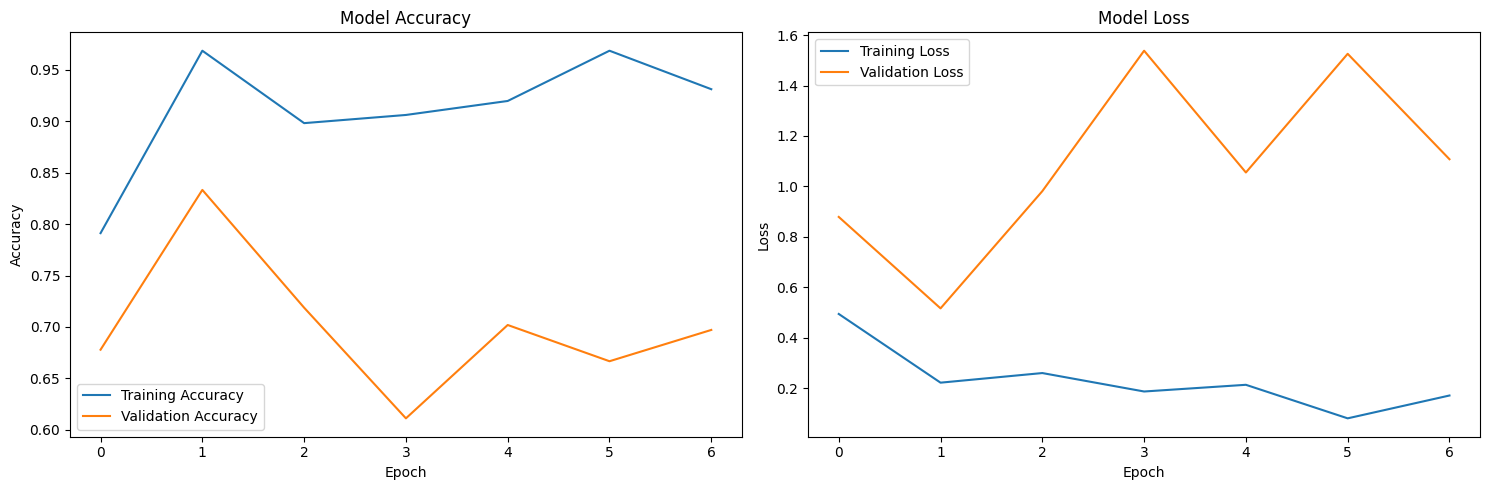


Evaluating model...
15/15 ━━━━━━━━━━━━━━━━━━━━ 149s 10s/step

Classification Report:
               precision    recall  f1-score   support

       NORMAL       0.80      0.92      0.85       160
    PNEUMONIA       0.90      0.81      0.85       160
TURBERCULOSIS       1.00      0.94      0.97       141

     accuracy                           0.89       461
    macro avg       0.90      0.89      0.89       461
 weighted avg       0.89      0.89      0.89       461



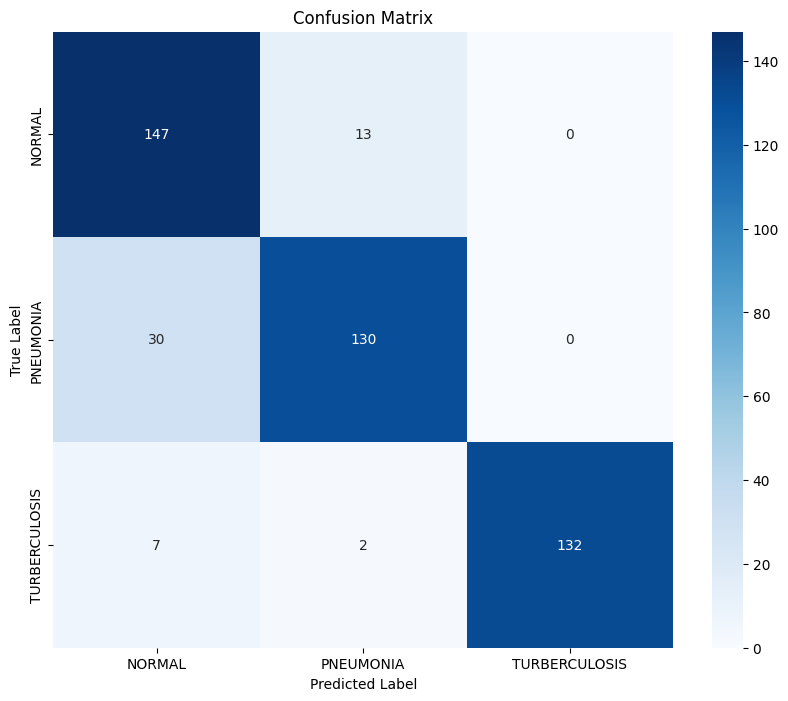


Model saved as 'final_densenet_model.h5'


In [ ]:
if __name__ == "__main__":
    main()

Copying the final model to google drive

In [ ]:
!cp 'final_densenet_model.h5' '/content/drive/MyDrive/final_densenet_model.h5'

In [ ]:
model=load_model('final_densenet_model.h5')